# Imports

In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
import sklearn

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import model_selection, ensemble, neighbors, linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

import inflection

from IPython.display            import Image
from IPython.core.display       import HTML

import warnings
warnings.filterwarnings("ignore")

## Helper Functions

In [31]:
## performance metrics

# definition of precision_at_k for the top 20.000 clients as default
def precision_at_k (data, k=2000):
    
    # reset index
    data = data.reset_index(drop=True)
    
    #create ranking order
    data['ranking'] = data.index + 1
    
    #calculate precision based on column named response
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return data.loc[k, 'precision_at_k']

# definition of recall_at_k for the top 20.000 clients as default
def recall_at_k (data, k=2000):
    
    # reset index
    data = data.reset_index(drop=True)
    
    #create ranking order
    data['ranking'] = data.index + 1
    
    #calculate recall based on the sum of responses
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return data.loc[k, 'recall_at_k']

##Define models accuracy function
def accuracy (model_name, x_val, y_val, yhat):
    
    x_val = x_val.copy()
    x_val['response'] = y_val.copy()
    x_val['score'] = yhat[:, 1].tolist()
    x_val = x_val.sort_values('score', ascending=False)
   
    precision = precision_at_k(x_val)      
    recall = recall_at_k(x_val)
    roc = roc_auc_score(y_val, yhat[:,1])
    
    return pd.DataFrame({'Model Name': model_name,
                         'ROC AUC': roc,
                         'Precision@K Mean': np.mean(precision).round(4),
                         'Precisio~n@K STD': np.std(precision).round(4),
                         'Recall@K Mean': np.mean(recall).round(4),
                         'Recall@K STD': np.std(recall).round(4)}, index=[0])

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

jupyter_settings();

Populating the interactive namespace from numpy and matplotlib


## Loading Data 

In [32]:
df_raw = pd.read_csv('data/train.csv')

# Data Details

In [33]:
df2 = df_raw.copy()

In [34]:
df2.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## Data Dictionary

|The data set that we're using is from Kaggle (https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction).



| Feature                                       |Description   
|:---------------------------|:---------------
| **Id**                         | Unique ID for the customer   | 
| **Gender**                           | Gender of the customer   | 
| **Driving License**                                   | 0, customer does not have DL; 1, customer already has DL  | 
| **Region Code**                               | Unique code for the region of the customer   | 
| **Previously Insured**                     | 1, customer already has vehicle insurance; 0, customer doesn't have vehicle insurance | 
| **Vehicle Age**                     | Age of the vehicle | 
| **Vehicle Damage**                                  | 1, customer got his/her vehicle damaged in the past; 0, customer didn't get his/her vehicle damaged in the past | 
| **Anual Premium**                             | The amount customer needs to pay as premium in the year | 
| **Policy sales channel**                                    | Anonymized Code for the channel of outreaching to the customer ie  | 
| **Vintage**                | Number of Days, customer has been associated with the company  | 
| **Response**              | 1, customer is interested; 0, customer is not interested. |    

## Rename Columns

In [35]:
cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 
            'Policy_Sales_Channel', 'Vintage', 'Response']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# rename
df2.columns = cols_new

## Data Dimensions

In [36]:
print ('Number of Rows: {}'.format( df2.shape[0]))
print ('Number of Columns: {}'.format( df2.shape[1]))

Number of Rows: 381109
Number of Columns: 12


## Data Types

In [37]:
df2.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## Missing Values

In [38]:
df2.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## Change Types

In [39]:
# changing data types from float to int64

df2['region_code'] = df2['region_code'].astype('int64')     

df2['policy_sales_channel'] = df2['policy_sales_channel'].astype('int64')    

df2['annual_premium'] = df2['annual_premium'].astype('int64')    


## Descriptive Statistics


In [40]:
# Split numerical and categorical features
num_attributes = df2.select_dtypes( include=['int64', 'float64'])
cat_attributes = df2.select_dtypes( exclude=['int64', 'float64'])

### Numerical Attributes

In [41]:
#Central Tendency - mean, meadian
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concat
m= pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes','min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


**Age** of customers ranges from 20 to 85 years old, average being close to 38.

**Driving Licence** ≈ 100% of the clients in analysis retain a one

**Vehicle insurance** ≈ 55% of the clients do not hold one

**Annual Premium** Clients pay ≈ 30.5k on their current health insurance policy

**Response** 12.23% of the clients showed to be interest in purchasing a vehicle insurance.

### Categorical Attributes

In [42]:
# add percentage of most common attribute
cat_attributes_p = cat_attributes.describe().T
cat_attributes_p['freq_p'] = cat_attributes_p['freq'] / cat_attributes_p['count']
cat_attributes_p

,count,unique,top,freq,freq_p
gender,381109,2,Male,206089,0.540761
vehicle_age,381109,3,1-2 Year,200316,0.525613
vehicle_damage,381109,2,Yes,192413,0.504877


**Gender** ≈ 54% of the customers are Male

**Vehicle Age** Customers age vehicle is most commonly between 1 and 2 years old

**Vehicle Damage** ≈ 50% of the customers got his/her vehicle damaged in the past

**TOP 3 Combos Categorical Attributes**

In [43]:
categorical_combo = pd.DataFrame(round(cat_attributes.value_counts(normalize=True) * 100)).reset_index().rename(columns={0: '%'})
categorical_combo['count'] = cat_attributes.value_counts().values
display(categorical_combo)

,gender,vehicle_age,vehicle_damage,%,count
0,Male,1-2 Year,Yes,21.0,79533
1,Female,< 1 Year,No,17.0,66047
2,Male,< 1 Year,No,13.0,50543
3,Female,1-2 Year,Yes,13.0,48692
4,Male,1-2 Year,No,11.0,42791
5,Female,1-2 Year,No,8.0,29300
6,Female,< 1 Year,Yes,7.0,25274
7,Male,< 1 Year,Yes,6.0,22922
8,Male,> 2 Years,Yes,3.0,10293
9,Female,> 2 Years,Yes,1.0,5699


**1.** Males with car age between 1-2 years old that got vehicle damaged in the past 

**2.** Female with car newer than 1 year old that never got vehicle damage in the past

**3.** Males with car newer than 1 year old that never got vehicle damage in the past

# Feature Engineering

In [44]:
df3 = df2.copy()

## Features Creation 

In [45]:
# vehicle age
df3['vehicle_age']= df3['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2year' if x== '1-2 Year' else 'between_1_2_year')
# vehicle damage
df3['vehicle_damage'] = df3['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

## Mind Map

# Exploratory Data Analysis (EDA)

In [46]:
df4 = df3.copy()

## Univariate Analysis

### Response Variable

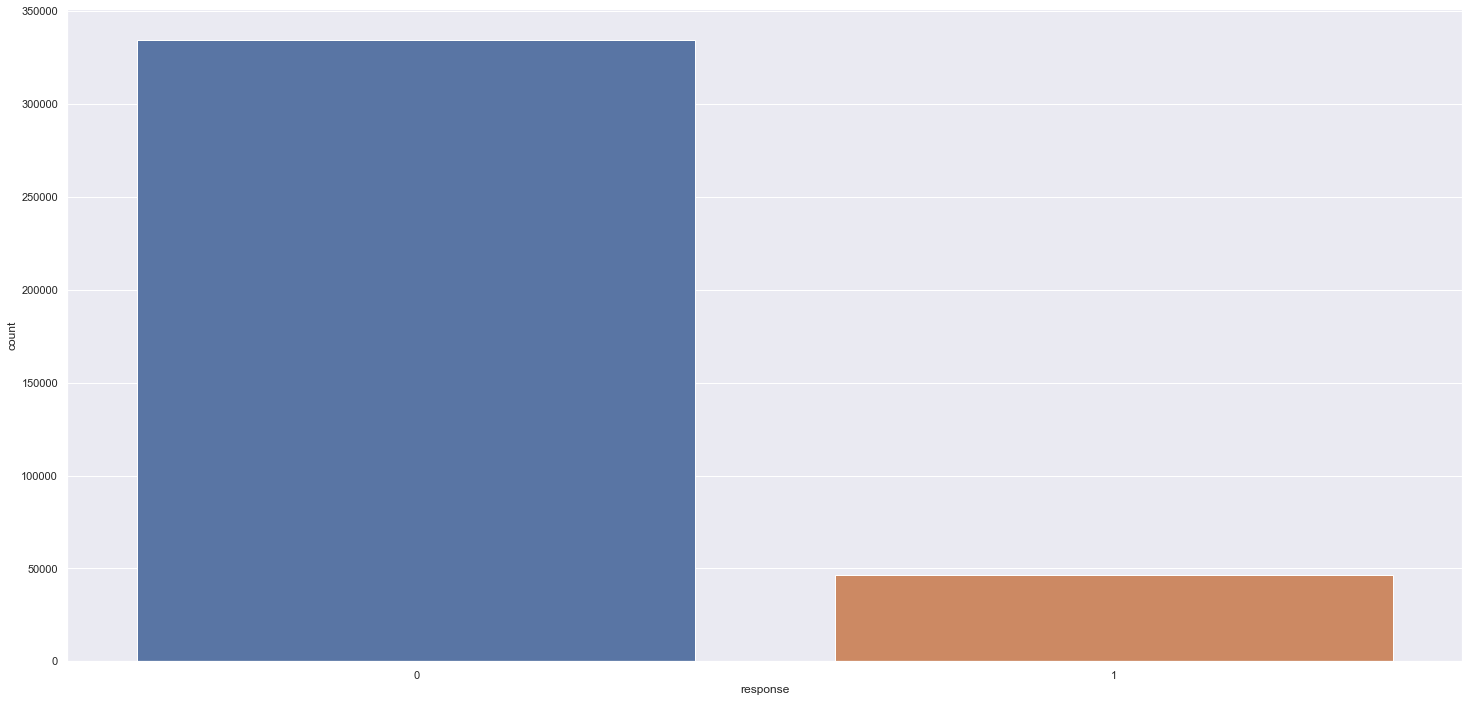

In [47]:
sns.countplot(x = 'response', data=df4);

### Numerical Variables

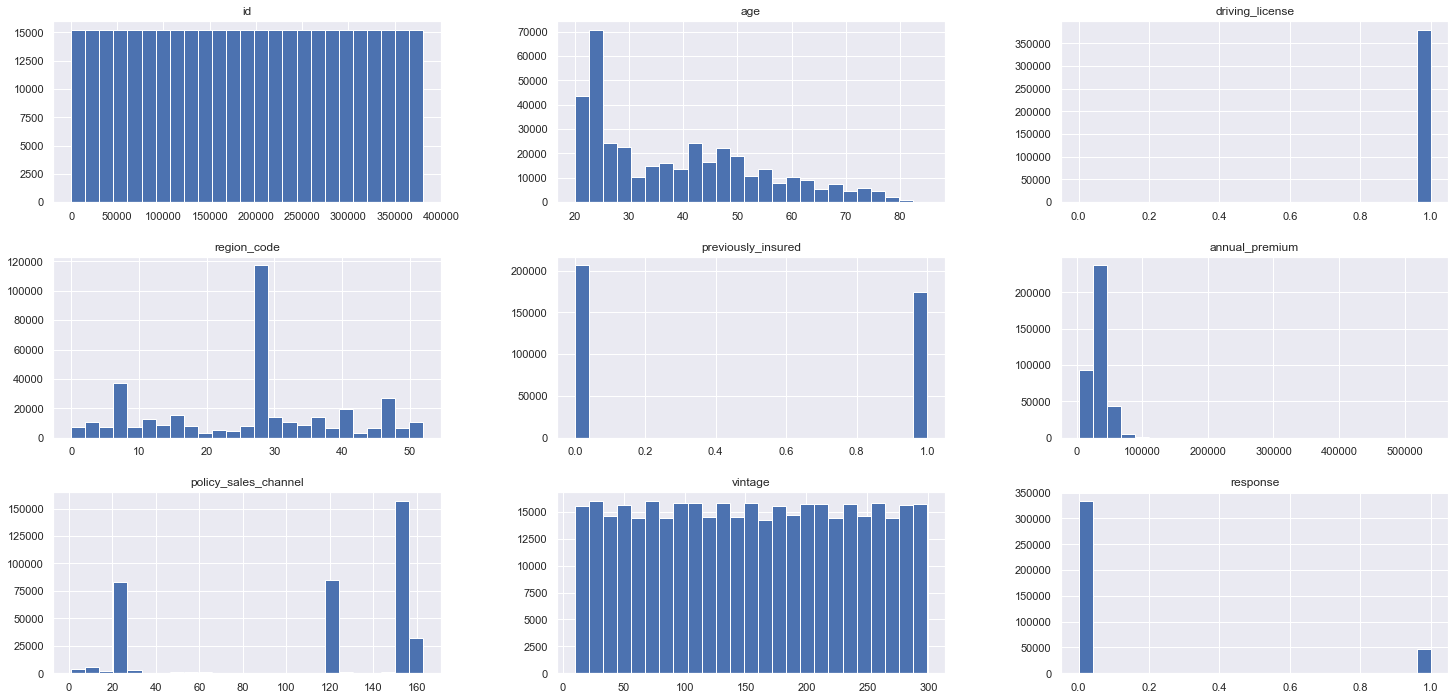

In [48]:
num_attributes.hist(bins=25);

#### Age

**Findings** The average age of interested clients is higher than non-interested clients. Both plots disclose well how younger clients are not as interested as older clients.

<AxesSubplot:xlabel='age', ylabel='Count'>

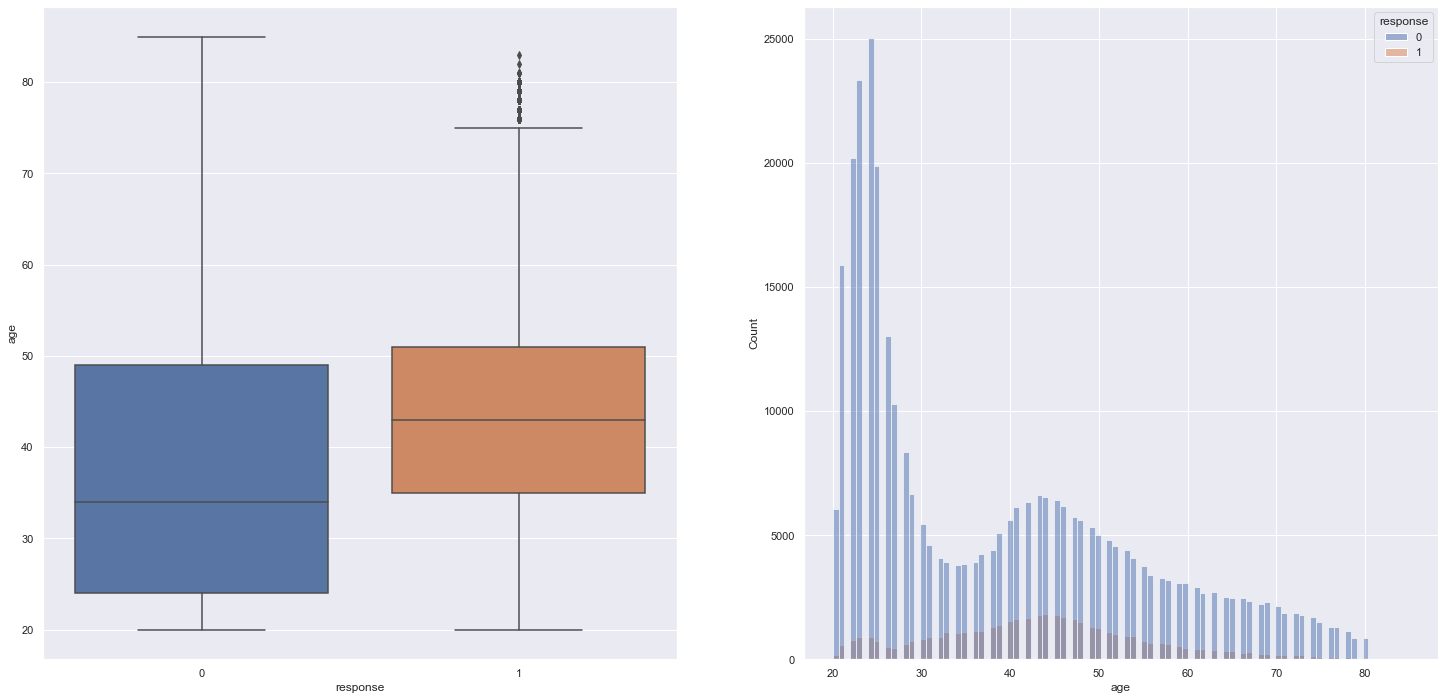

In [49]:
plt.subplot(1, 2, 1)
sns.boxplot( x='response', y='age', data=df4 )

plt.subplot(1, 2, 2)
sns.histplot(df4, x='age', hue='response');

#### Driving Licence
**Findings** Only clients holding a driving license are part of the dataset. 12% are potential vehicle insurance customers

In [50]:
aux2 = pd.DataFrame(round(df4[['driving_license', 'response']].value_counts(normalize=True) * 100)).reset_index().rename(columns={0: '%'})
aux2['count'] = (aux2['%'] * df4.shape[0]).astype(int)
aux2

,driving_license,response,%,count
0,1,0,88.0,33537592
1,1,1,12.0,4573308
2,0,0,0.0,0
3,0,1,0.0,0


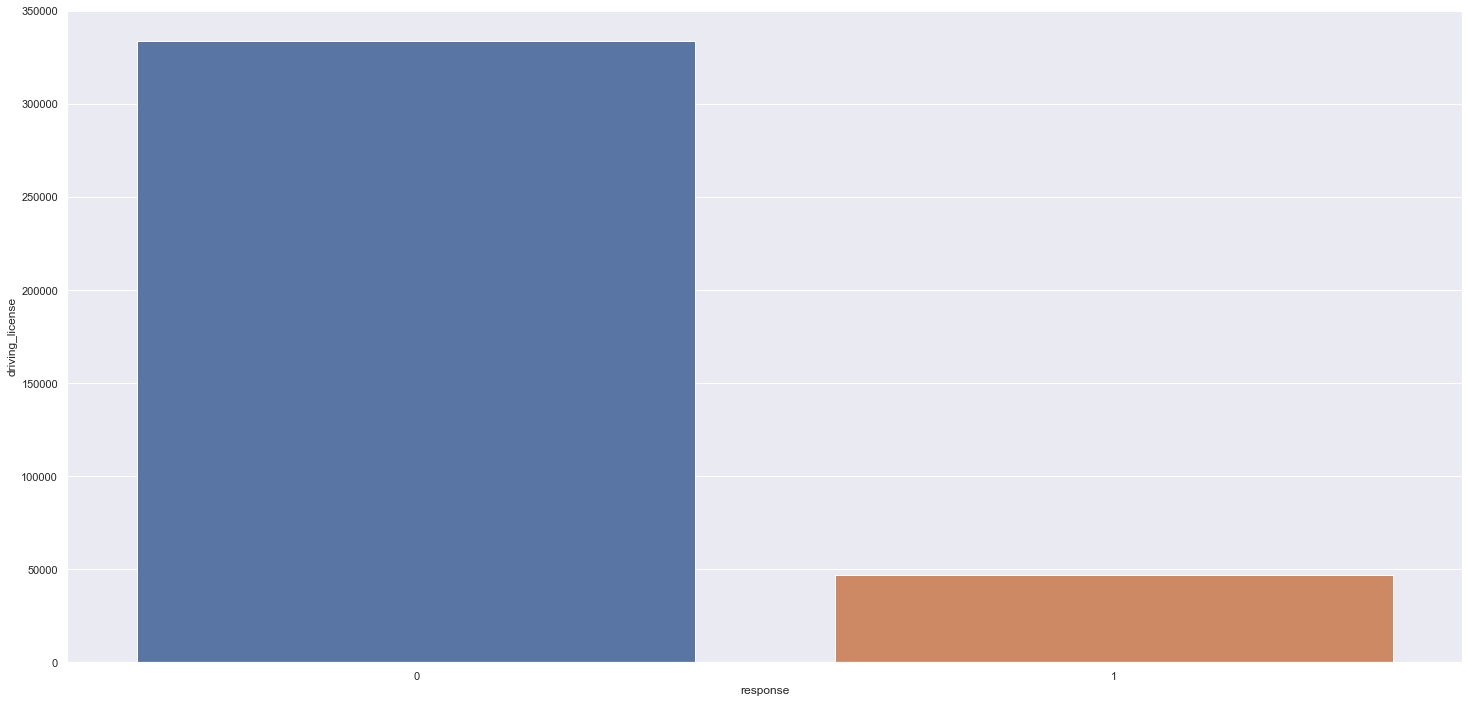

In [51]:
aux2 = df4[['driving_license', 'response']].groupby( 'response' ).sum().reset_index()
sns.barplot( x='response', y='driving_license', data=aux2 );

#### Region Code

<AxesSubplot:xlabel='region_code', ylabel='id'>

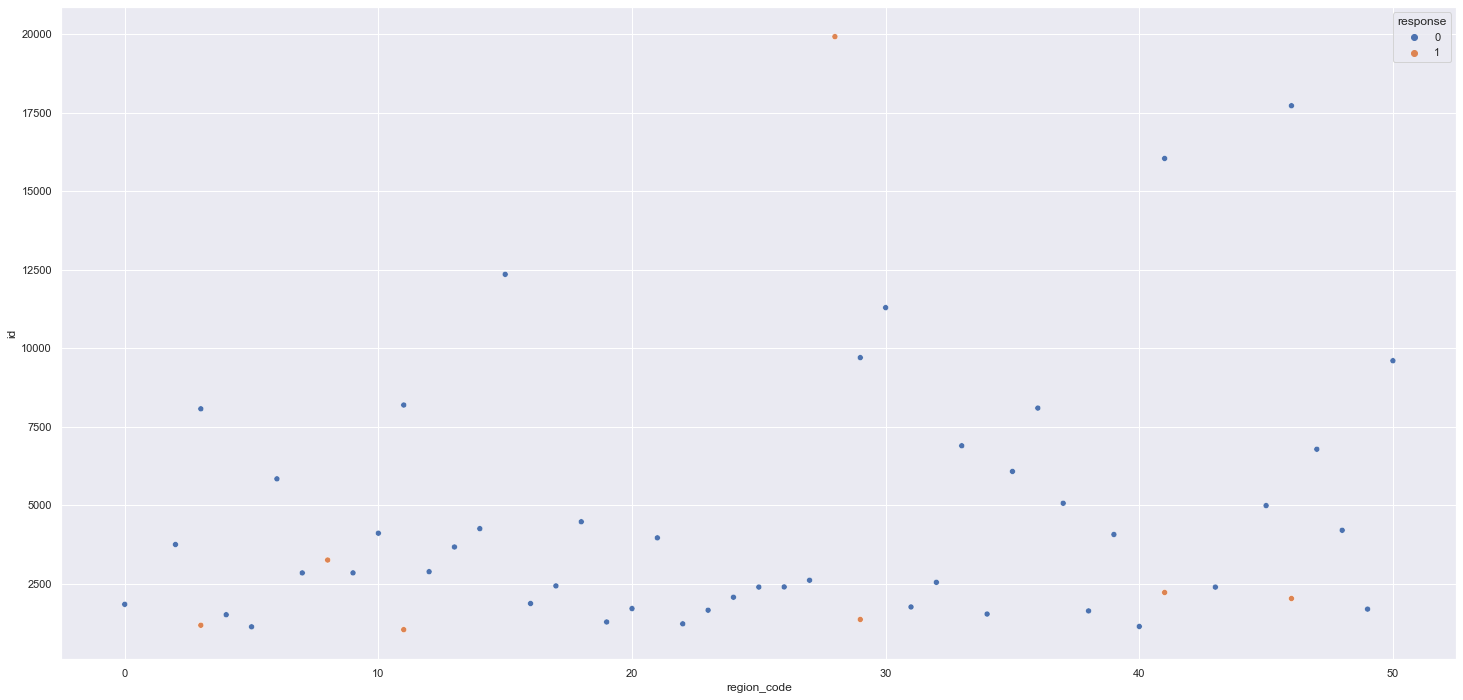

In [52]:
aux3 = df4[['id', 'region_code', 'response']].groupby( ['region_code', 'response'] ).count().reset_index()
aux3 = aux3[(aux3['id'] > 1000) & (aux3['id'] < 20000)]
sns.scatterplot( x='region_code', y='id', hue='response', data=aux3 );

#### Previously Insured
**Findings** All potential vehicle insurance customers have never held an insurance. 46% of our clients already have vehicle insurance and are not interested.

In [53]:
aux4 = pd.DataFrame(round(df4[['previously_insured', 'response']].value_counts(normalize=True) * 100)).reset_index().rename(columns={0: '%'})
aux4['count'] = (aux4['%'] * df4.shape[0]).astype(int)
aux4

,previously_insured,response,%,count
0,1,0,46.0,17531014
1,0,0,42.0,16006578
2,0,1,12.0,4573308
3,1,1,0.0,0


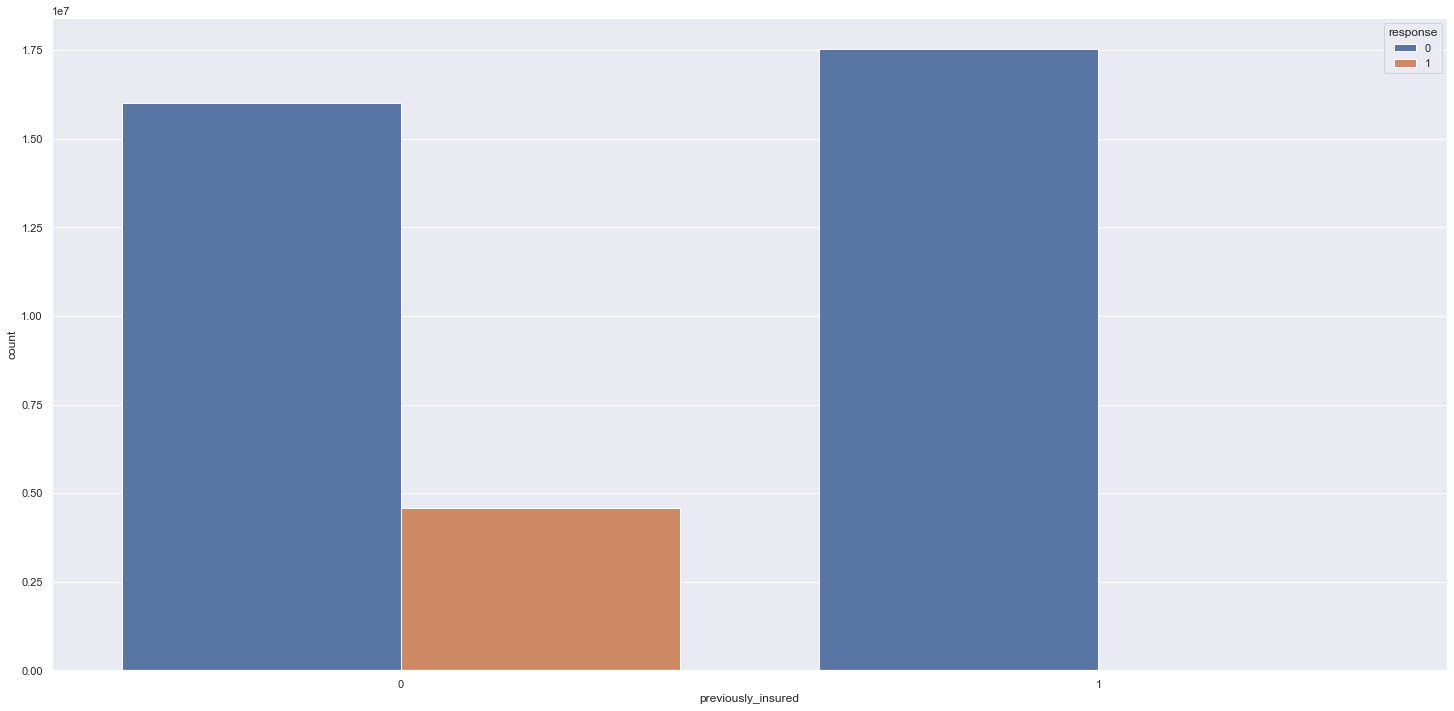

In [54]:
sns.barplot(data=aux4, x='previously_insured', y='count', hue='response');

#### Annual Premium
**Findings** Annual premiums for both interested and non-interested clients are very similar.

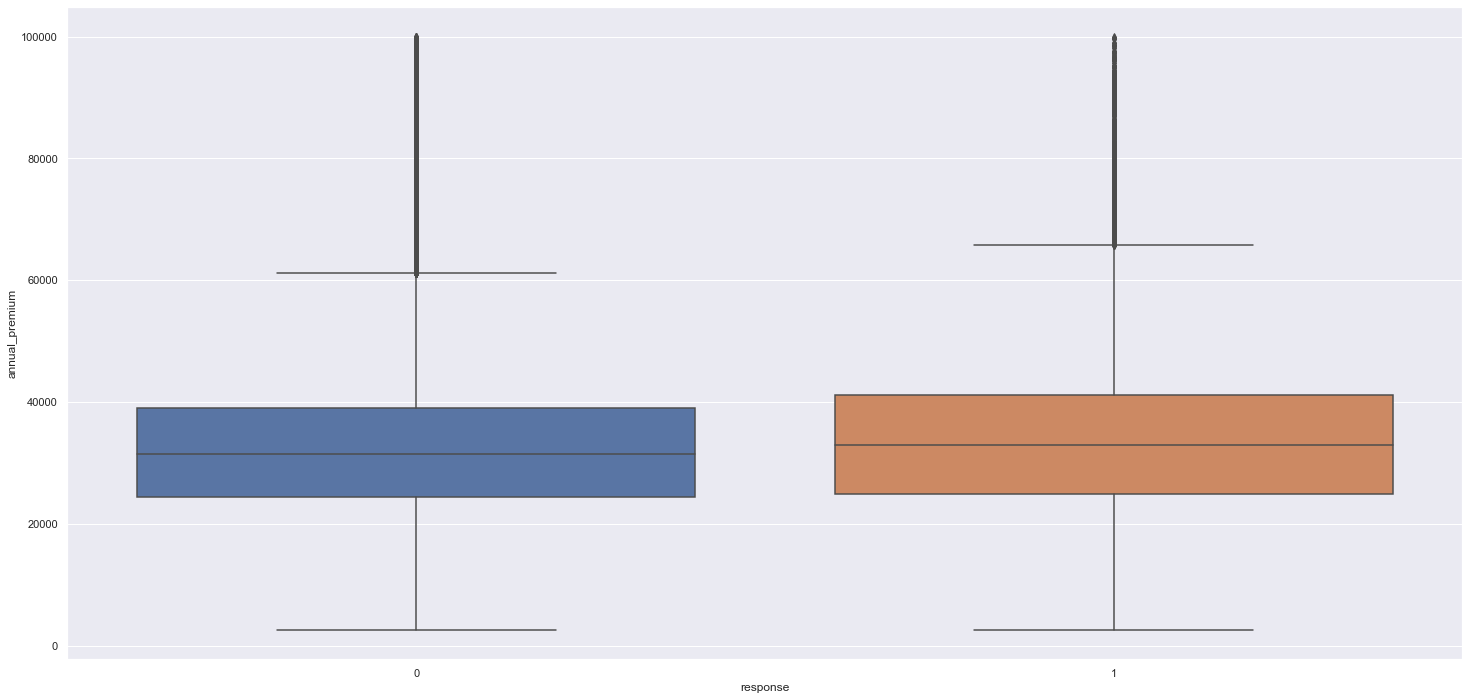

In [55]:
aux5 = df4[(df4['annual_premium'] <100000)]
sns.boxplot( x='response', y='annual_premium', data=aux5 );

#### Policy Sales Channel
**Findings**

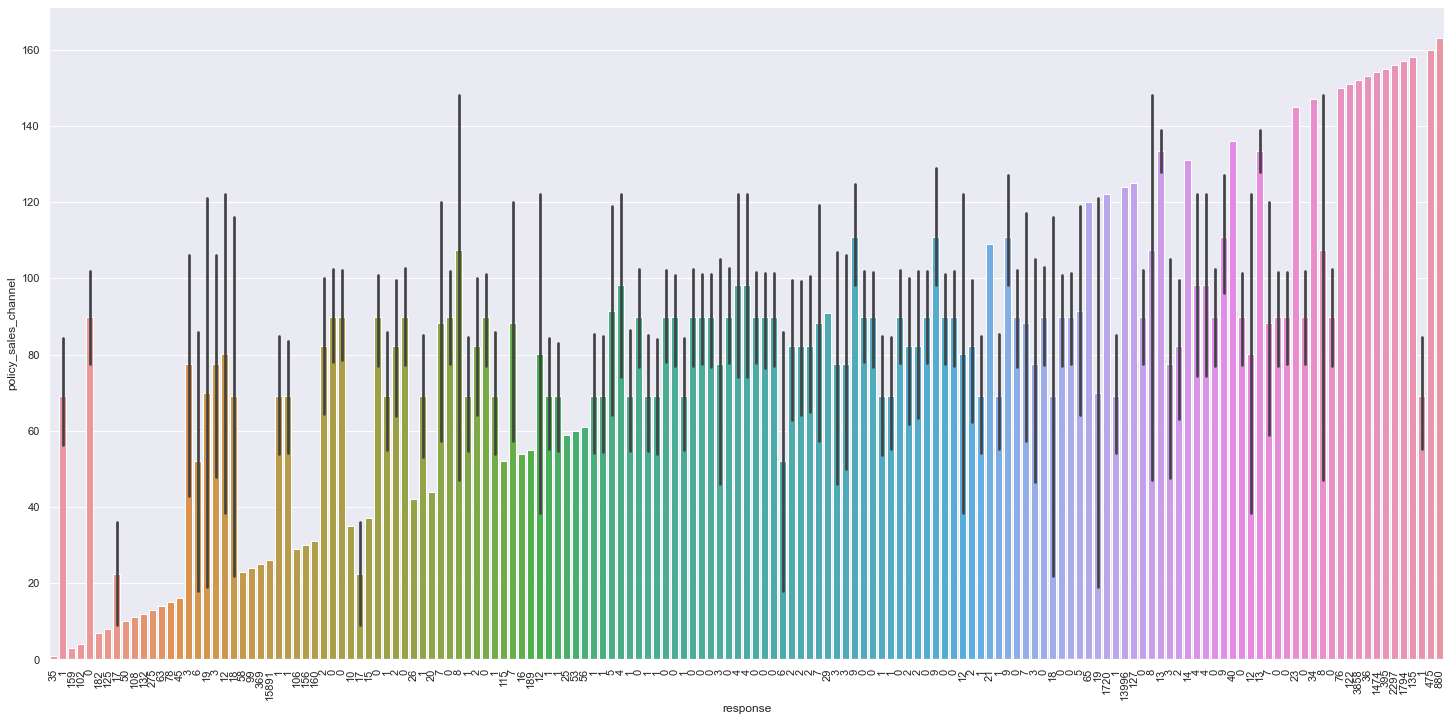

In [56]:
aux6 = df4[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel' ).sum().reset_index()

plt.xticks(rotation=90)
ax6 = sns.barplot( x='response', y='policy_sales_channel', data=aux6, order = aux6['response']);

In [ ]:
aux6 = df4[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel' ).sum().reset_index()

plt.xticks(rotation=90)
ax6 = sns.barplot( x='response', y='policy_sales_channel', data=aux6, order = aux6['response']);

#### Vintage
**Findings**

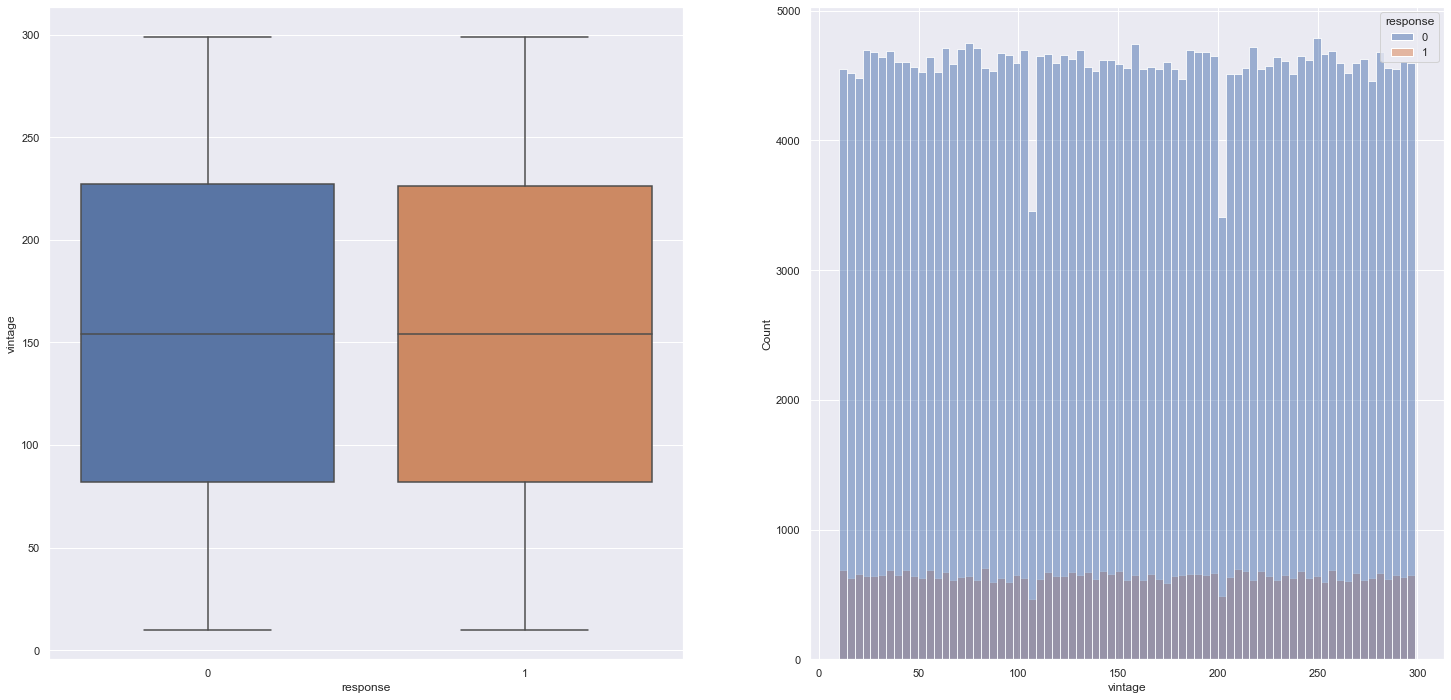

In [57]:
plt.subplot(1, 2, 1)
sns.boxplot( x='response', y='vintage', data=df4 )

plt.subplot(1, 2, 2)
sns.histplot(df4, x='vintage', hue='response');

### Categorical Variables

#### Gender

In [58]:
aux7 = pd.DataFrame(round(df4[['gender', 'response']].value_counts(normalize=True) * 100)).reset_index().rename(columns={0: '%'})
aux7['count'] = (aux7['%'] * df4.shape[0]).astype(int)
aux7

,gender,response,%,count
0,Male,0,47.0,17912123
1,Female,0,41.0,15625469
2,Male,1,7.0,2667763
3,Female,1,5.0,1905545


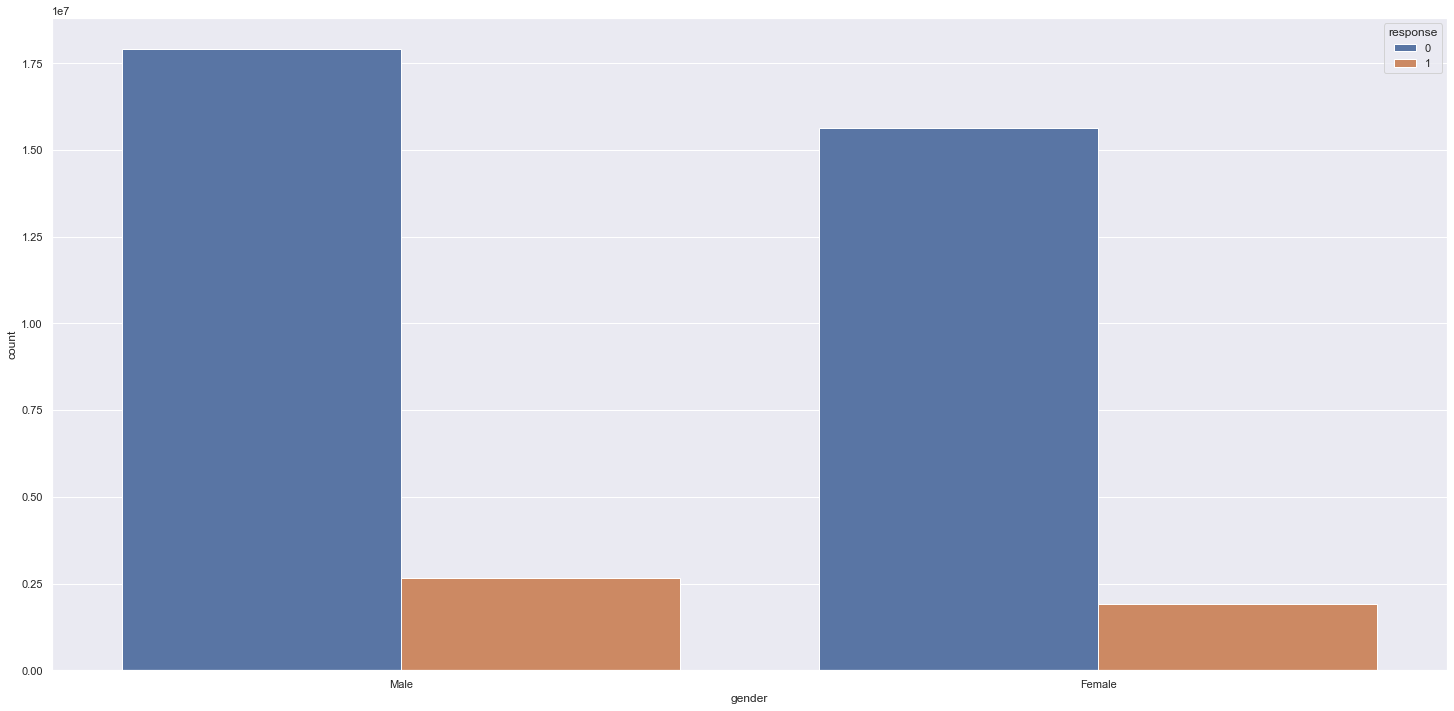

In [59]:
sns.barplot(data=aux7, x='gender', y='count', hue='response');

#### Vehicle Age

In [60]:
aux8 = pd.DataFrame(round(df4[['vehicle_age', 'response']].value_counts(normalize=True) * 100)).reset_index().rename(columns={0: '%'})
aux8['count'] = (aux8['%'] * df4.shape[0]).astype(int)
aux8

,vehicle_age,response,%,count
0,between_1_2year,0,43.0,16387687
1,between_1_2_year,0,41.0,15625469
2,between_1_2year,1,9.0,3429981
3,over_2_years,0,3.0,1143327
4,between_1_2_year,1,2.0,762218
5,over_2_years,1,1.0,381109


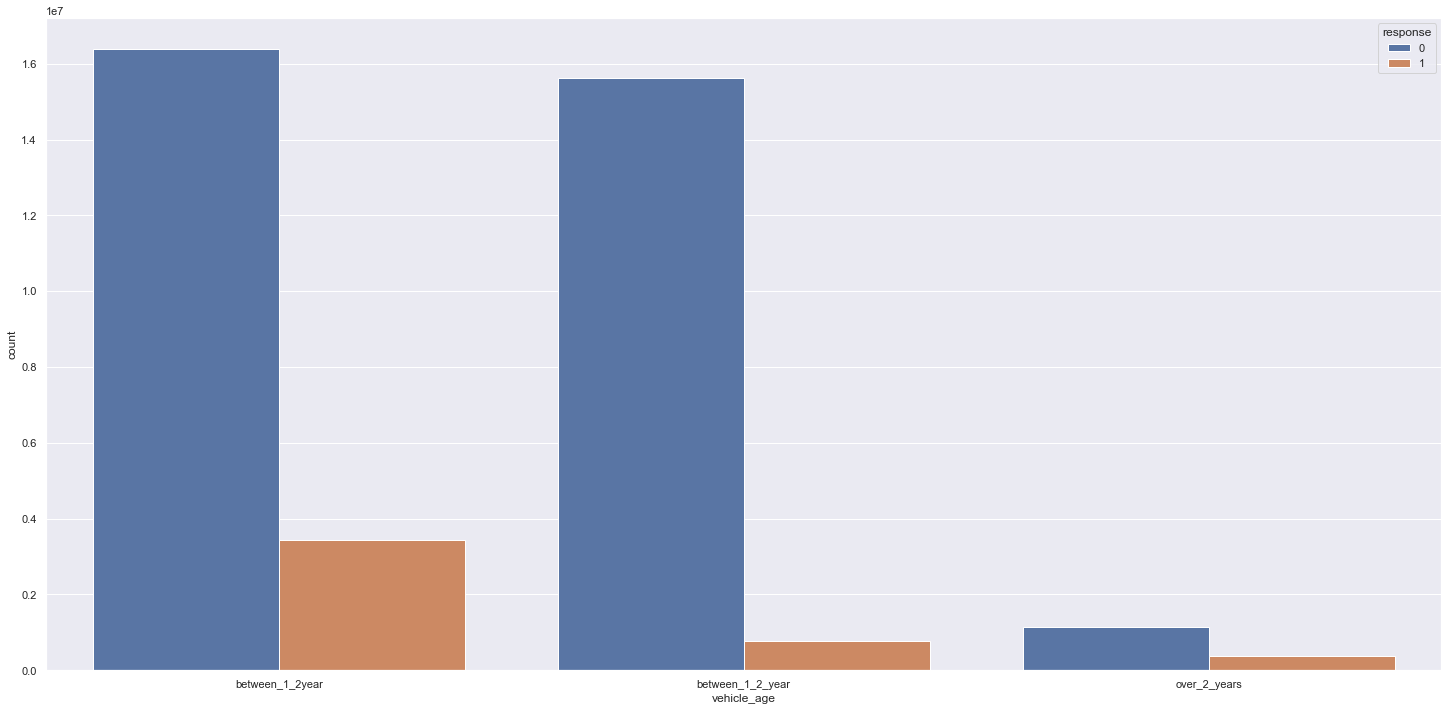

In [61]:
sns.barplot(data=aux8, x='vehicle_age', y='count', hue='response');

#### Vehicle Damage

In [62]:
aux9 = pd.DataFrame(round(df4[['vehicle_damage', 'response']].value_counts(normalize=True) * 100)).reset_index().rename(columns={0: '%'})
aux9['count'] = (aux9['%'] * df4.shape[0]).astype(int)
aux9

,vehicle_damage,response,%,count
0,0,0,49.0,18674341
1,1,0,38.0,14482142
2,1,1,12.0,4573308
3,0,1,0.0,0


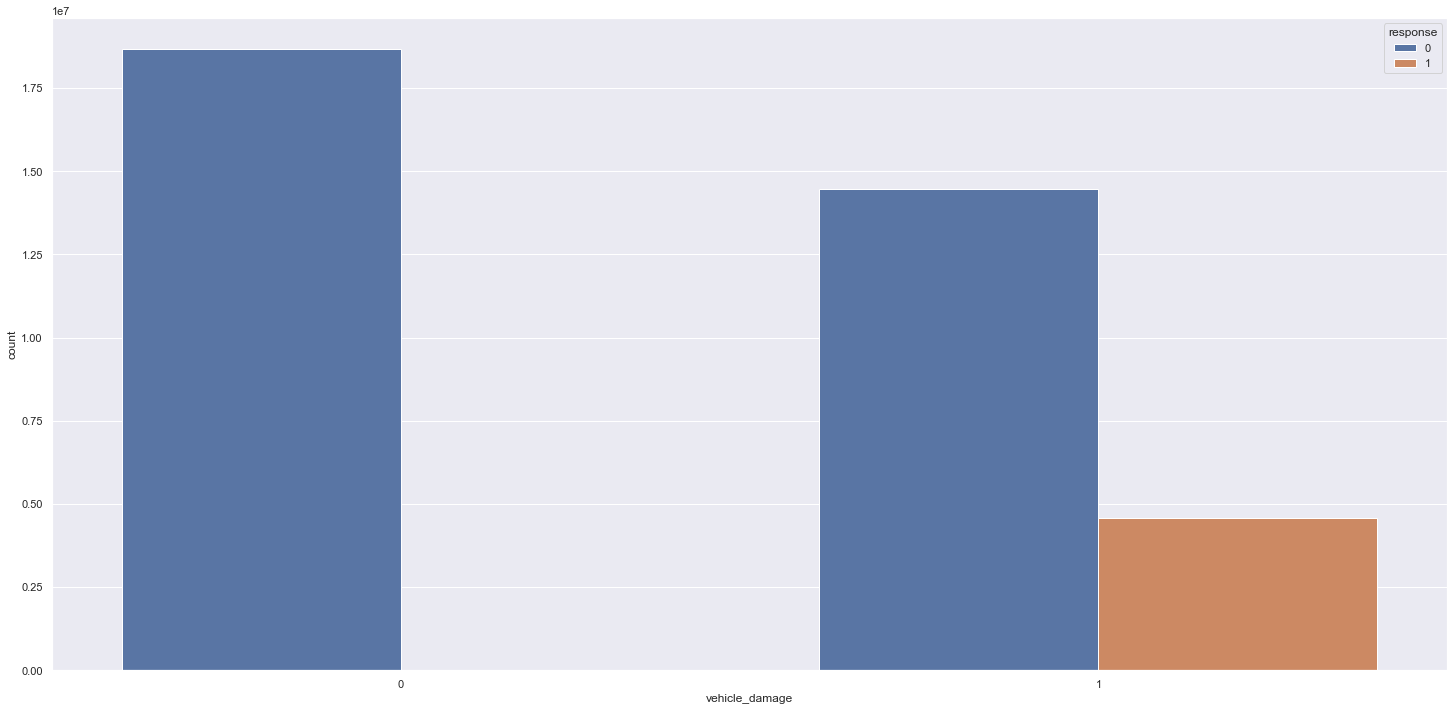

In [63]:
sns.barplot(data=aux9, x='vehicle_damage', y='count', hue='response');

## Bivariate Analysis

## Multivariate Analysis

### Numerical Attributed
**Finding** Having the target variable in scope, the stronger correlations with feature 'Previously Insured' (-0.34), 'Policy Sales Channel' (-0.14) and 'Age' (0.11). Outside the target variable scope, between Age and Policy Sales Chanel there is strong negative correlation of -0.58), 'Previously Insured' and 'Age' of -0.25 and last between 'Previously Insured' and 'Policy Sales Channel' 0.22. 

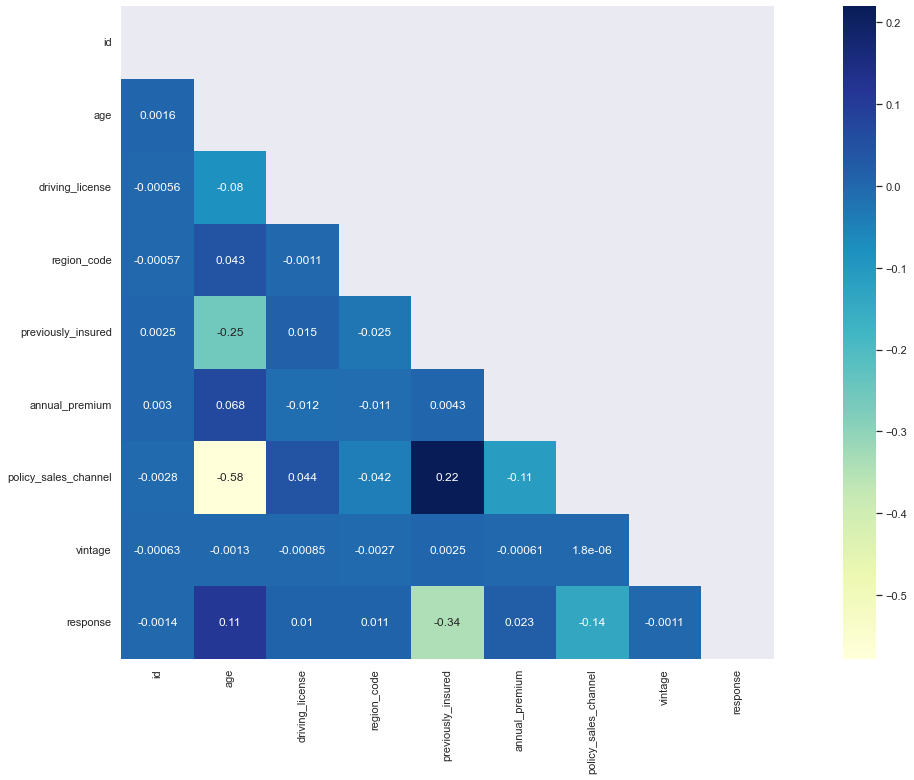

In [65]:
corr_matrix= num_attributes.corr()
# Half matrix
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_matrix, mask = mask, annot = True, square = True, cmap='YlGnBu');

# Data Preparation

In [66]:
df5 = df4.copy()

## Standardization of DataSets 

In [67]:
df5['annual_premium'] = StandardScaler().fit_transform( df5[['annual_premium']].values)

## Rescaling

In [68]:
mms = MinMaxScaler()

#age
df5['age'] = mms.fit_transform( df5[['age']].values)

#vintage
df5['vintage'] = mms.fit_transform( df5[['vintage']].values)

## Transformation

### Encoding

In [69]:
#gender - target encoder
target_encode_gender = df5.groupby('gender')['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map(target_encode_gender)

# region_code - Target Encoding - as there are plenty of categories (as seen in EDA) it is better not to use one hot encoding and to use 
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map(target_encode_region_code)

#vehicle_age
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

#policy_sales_channel - Frequency encode
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size()/len( df5)
df5['policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)

# Feature Selection

In [70]:
df6 = df5.copy()

## Split dataframe into training and test

In [71]:
X = df6.drop('response', axis=1)
y = df6['response'].copy()

x_train, x_val, y_train, y_val = model_selection.train_test_split(X, y, test_size = 0.2)

df6 = pd.concat ( [x_train, y_train], axis = 1)

## Feature Importance

In [72]:
forest = ensemble.ExtraTreesClassifier( n_estimators = 250, random_state = 42, n_jobs = -1)

x_train_n = df6.drop(['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=42)

Feature Rankings
                        feature  importance
0                       vintage    0.273093
0                annual_premium    0.244952
0                           age    0.162584
0                   region_code    0.106075
0                vehicle_damage    0.072502
0          policy_sales_channel    0.063117
0            previously_insured    0.050997
0  vehicle_age_between_1_2_year    0.012158
0   vehicle_age_between_1_2year    0.006150
0                        gender    0.005447
0      vehicle_age_over_2_years    0.002449
0               driving_license    0.000476


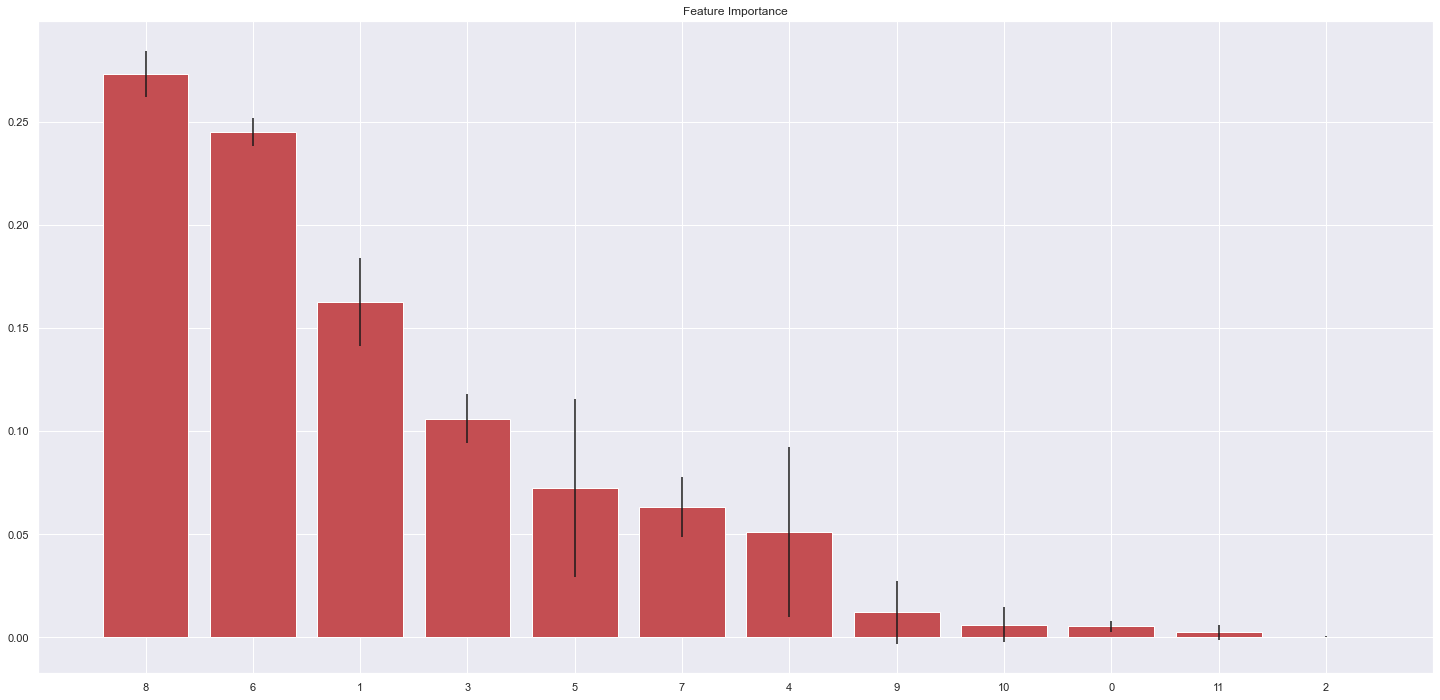

In [73]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)
indices = np.argsort(importances)[::-1]
#print the feature ranking
print( "Feature Rankings")
df = pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame( {'feature': i, 'importance':j}, index=[0])
    df = pd.concat ([df, aux], axis = 0)
    
print( df.sort_values( 'importance', ascending=False))

# PLt the impurity-based feature importance of the features
plt.figure()
plt.title('Feature Importance')
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# Machine Learning Modelling

In [74]:
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 
                 'vehicle_damage', 'policy_sales_channel']

cols_not_selected = ['previously_insured', 'vehicle_age_between_1_2_year', 'vehicle_age_between_1_2year', 'gender', 'vehicle_age_over_2_years', 'driving_license']

#create df to be used for business understading
x_validation = x_val.drop(cols_not_selected, axis=1)

#create dfs for modeling
x_train = df6[cols_selected]
x_val = x_val[cols_selected]

## KNN Classifier

### Model Building

In [75]:
#define model
knn = neighbors.KNeighborsClassifier (n_neighbors = 8)

#train model
knn.fit( x_train, y_train)

#model prediction
yhat_knn = knn.predict_proba( x_val)

### Model Single Performance

In [80]:
accuracy_knn = accuracy(knn, x_val, y_val, yhat_knn)

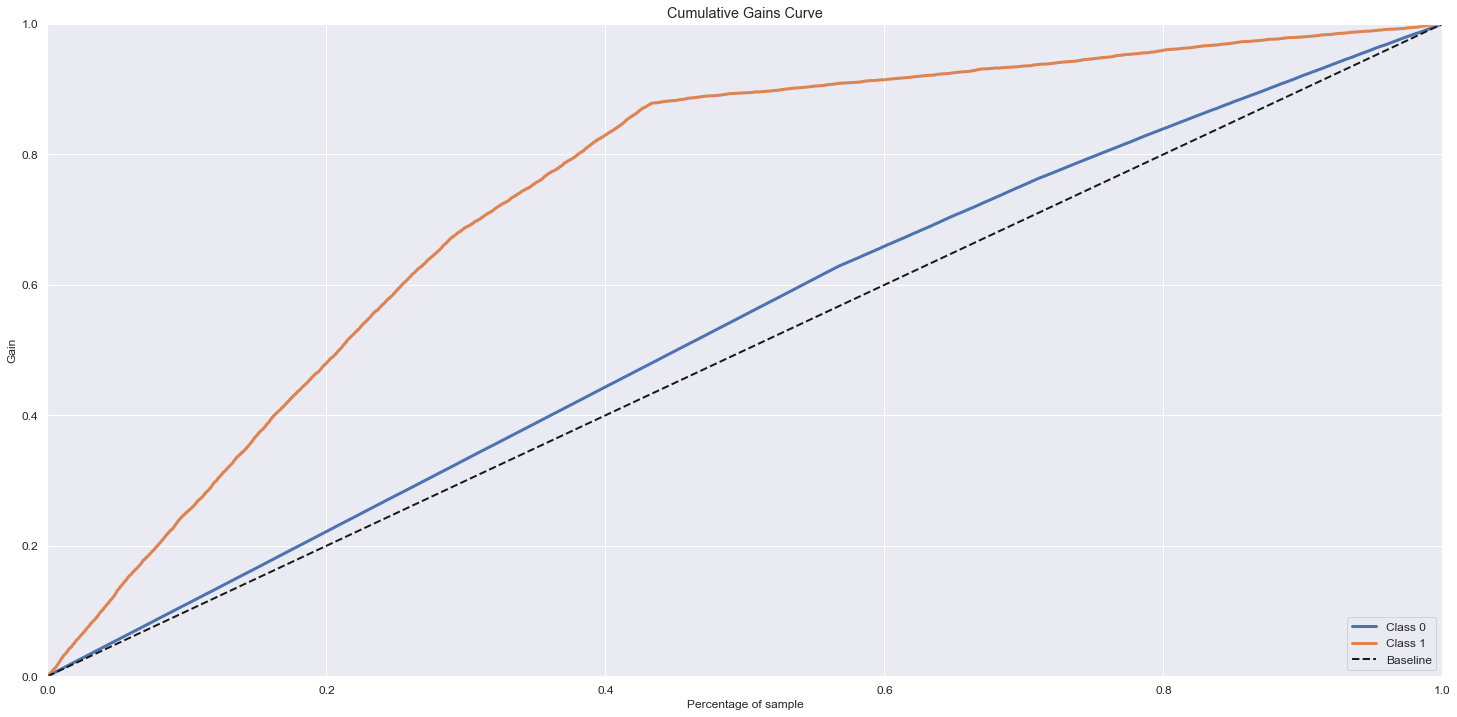

In [81]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn);

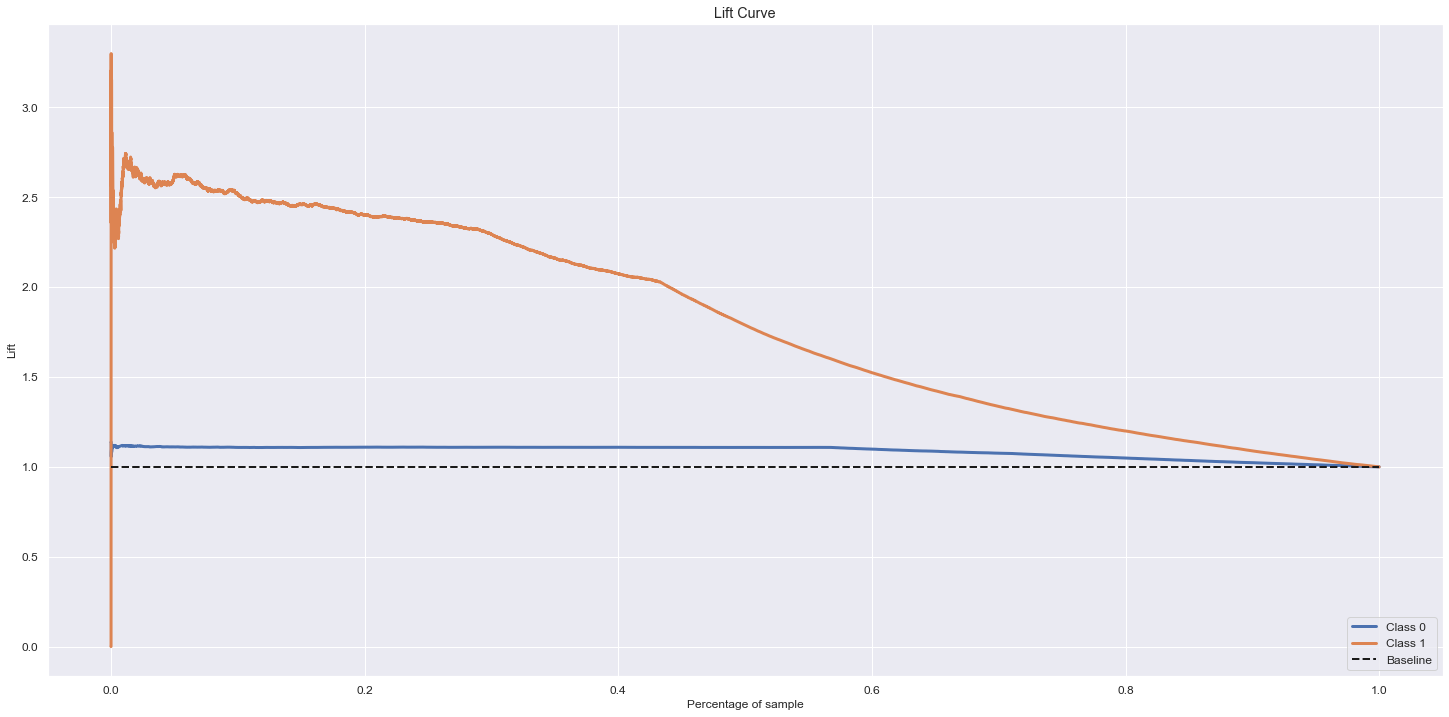

In [82]:
# Lift Curve
skplt.metrics.plot_lift_curve( y_val, yhat_knn );

### Cross Validation

## Extra Trees

### Model Building

In [83]:
#define model
et = ensemble.ExtraTreesClassifier (n_estimators = 1000, random_state = 42, n_jobs=-1)

#train model
et.fit( x_train, y_train)

#model prediction
yhat_et = et.predict_proba( x_val)

### Model Single Performance

In [ ]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_et);

In [ ]:
# Lift Curve
skplt.metrics.plot_lift_curve( y_val, yhat_et );

### Model Accuracy

## Logistic Regression

### Model Building

In [86]:
#define model
lr = linear_model.LogisticRegression (random_state = 42)

#train model
lr.fit( x_train, y_train)

#model prediction
yhat_lr = lr.predict_proba( x_val)

### Model Single Performance

In [92]:
accuracy_lr = accuracy(lr, x_val, y_val, yhat_lr)
accuracy_lr

,Model Name,ROC AUC,Precision@K Mean,Precisio~n@K STD,Recall@K Mean,Recall@K STD
0,LogisticRegression(random_state=42),0.803226,0.2824,0.0,0.0611,0.0


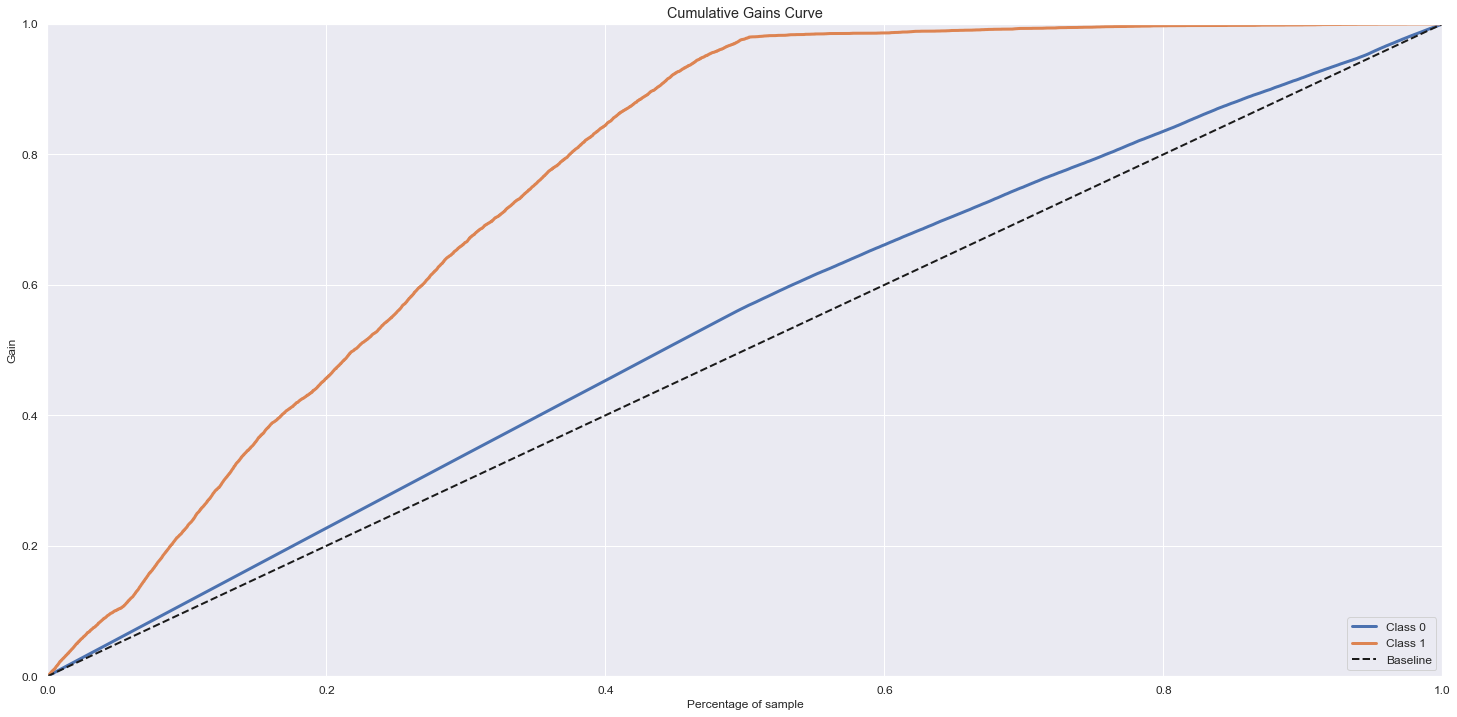

In [90]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr);

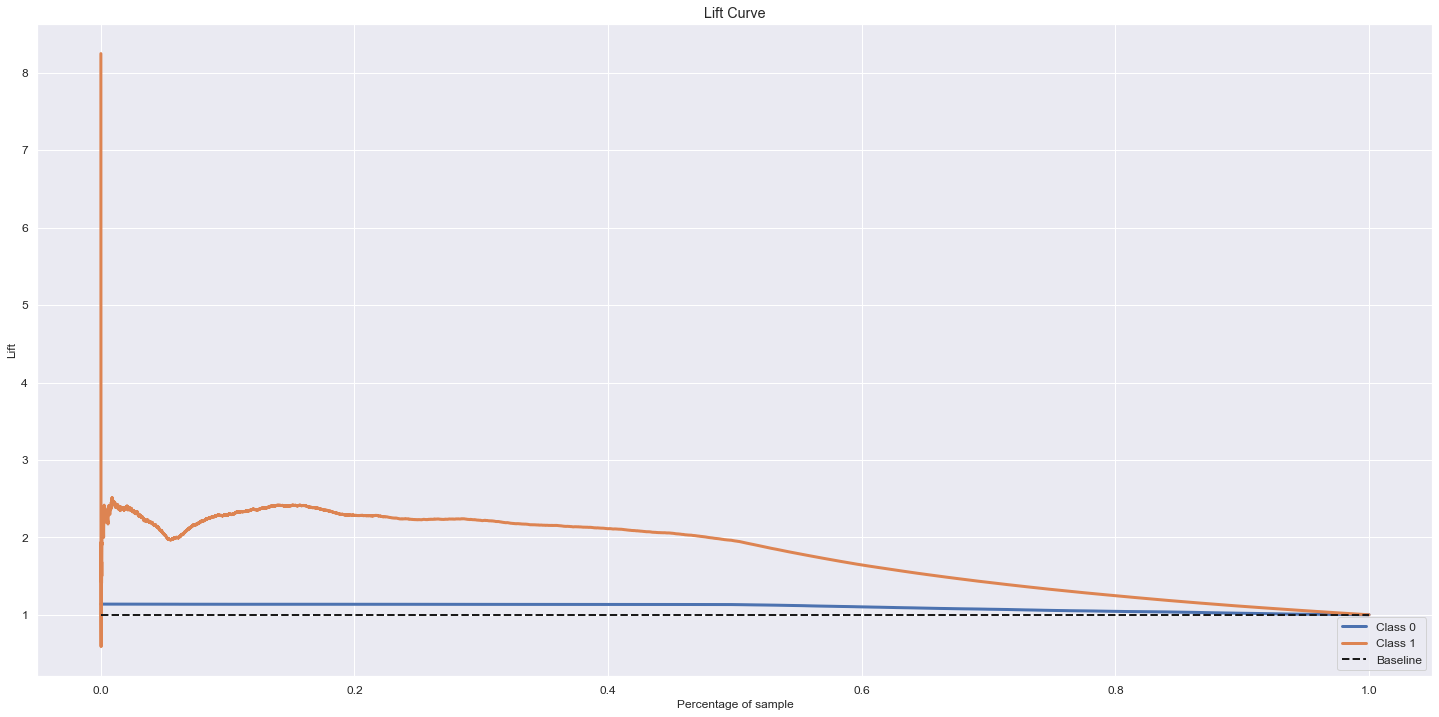

In [91]:
# Lift Curve
skplt.metrics.plot_lift_curve( y_val, yhat_lr );

## Random Forest Regressor

### Model Building

In [ ]:
#Create a Gaussian Classifier
rf=RandomForestClassifier(n_estimators=100, min_samples_leaf=25)

#train model
rf.fit( x_train, y_train)

#model prediction
yhat_rf = lr.predict_proba( x_val)

### Model Single Performance

In [ ]:
accuracy_rf = accuracy(et, x_val, y_val, yhat_rf)

In [ ]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_rf);

In [ ]:
# Lift Curve
skplt.metrics.plot_lift_curve( y_val, yhat_rf );

# Performance Metrics

In [ ]:
df8 = x_validation.copy()
df8['response'] = y_val
df8.head()

## KNN

In [ ]:
# propensity score
df8['score'] = yhat_knn[:,1].tolist()

#sort clients by PS
df8 = df8.sort_values('score', ascending=False)

In [ ]:
#compute precision at k
precision_at_50 = precision_at_k(df8, 50)
print('Precision at K:{}'.format(precision_at_50))

#compute recall at k
recall_at_50 = recall_at_k(df8, 50)
print('Recall at K:{}'.format(recall_at_50))

# Hyperparameter Fine Tuning

# Error translation and Interpretation